# Random Forest Project

Let's take some data from LendingClub.com and see if we can predict who is likely to pay back one of their peer-to-peer loans. These data come from 2007-2010.

## Import Libraries

In [62]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Get the Data

Here are what the columns represent:

| feature | description |
| ------- | ----------- |
| credit.policy | 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
| purpose | The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", and "all_other").
| int.rate | The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates.
| installment | The monthly installments owed by the borrower if the loan is funded.
| log.annual.inc | The natural log of the self-reported annual income of the borrower.
| dti | The debt-to-income ratio of the borrower (amount of debt divided by annual income).
| fico | The FICO credit score of the borrower.
| days.with.cr.line | The number of days the borrower has had a credit line.
| revol.bal | The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).
| revol.util | The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).
| inq.last.6mths | The borrower's number of inquiries by creditors in the last 6 months.
| delinq.2yrs | The number of times the borrower had been 30+ days past due on a payment in the past 2 years.
| pub.rec | The borrower's number of derogatory public records (bankruptcy filings, tax liens, or judgments).

The target is `not.fully.paid` which tracks whether the customer defaulted on a loan... I think. This data has been messed with and this column does not exist in the original dataset no is it explained in the notebook.

In [63]:
loans = pd.read_csv('loan_data.csv')
display(loans.head(), loans.info(), loans.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
credit.policy        9578 non-null int64
purpose              9578 non-null object
int.rate             9578 non-null float64
installment          9578 non-null float64
log.annual.inc       9578 non-null float64
dti                  9578 non-null float64
fico                 9578 non-null int64
days.with.cr.line    9578 non-null float64
revol.bal            9578 non-null int64
revol.util           9578 non-null float64
inq.last.6mths       9578 non-null int64
delinq.2yrs          9578 non-null int64
pub.rec              9578 non-null int64
not.fully.paid       9578 non-null int64
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


None

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


## Poking Around the Data

Let's take a look at the FICO scores of customers who met credit underwriting criteria (`credit.policy=1`) vs those who did not (`credit.policy=0`).

The fact that people who did not satisfy the criteria were still able to borrow is worrying. I supposed lenders were able to tack on higher interest rates and knew that they were taking more severe risks.

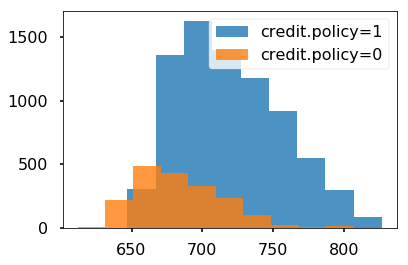

In [64]:
fig, ax = plt.subplots()
for category in [1, 0]:
    loans[loans['credit.policy'] == category]['fico'].hist(bins=10, grid=False,  alpha=0.8, label=f'credit.policy={category}')
plt.legend()

Let's not compare the FICO scores of customers who paid back their loans in full versus those who did not.

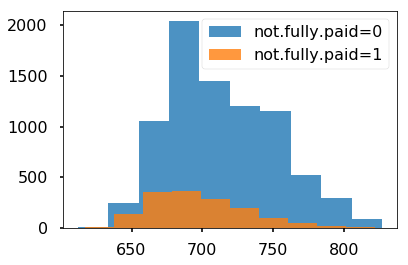

In [65]:
fig, ax = plt.subplots()
for category in [0, 1]:
    loans[loans['not.fully.paid'] == category]['fico'].hist(alpha=0.8, grid=False, label=f'not.fully.paid={category}')
plt.legend()

How many loans were given for each purpose, and how many were paid in full or not?

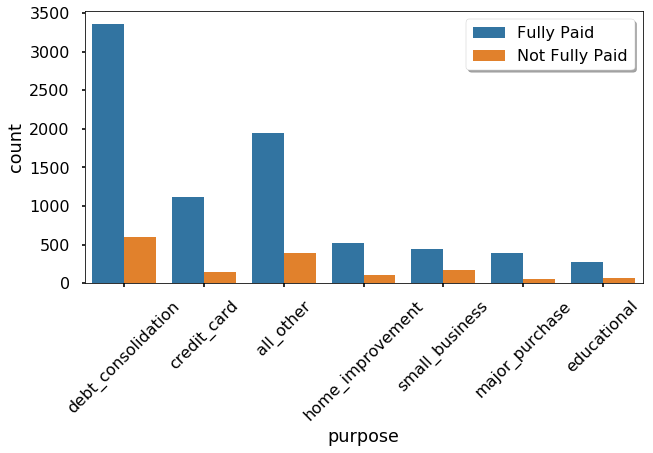

In [66]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x=loans['purpose'], hue=loans['not.fully.paid'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.legend(['Fully Paid', 'Not Fully Paid'], shadow=1)
plt.show()

What's the trend between FICO score and interest rate?

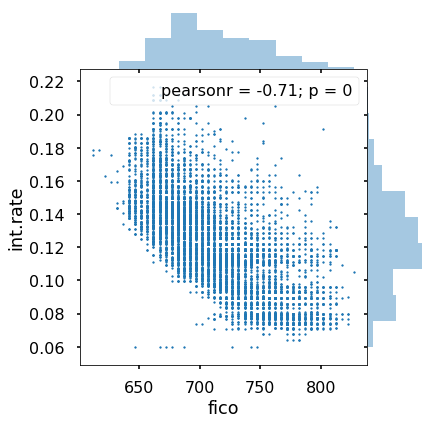

In [67]:
sns.jointplot(data=loans, x='fico', y='int.rate', space=0, marginal_kws={'bins': 10}, joint_kws={'s': 3})

Certainly one's FICO score is a strong predictor of what kind of interest rate they'll end up with. It looks like there is some kind of function for FICO that determines a minimum interest rate, aside from a handful of outliers. Who got a 6% interest rate with a FICO of less than 650? Maybe some extremely generous lender who ignored the advice from LendingClub.

Now let's use lmplots to visualize the differences between credit policies and paid-in-full status.

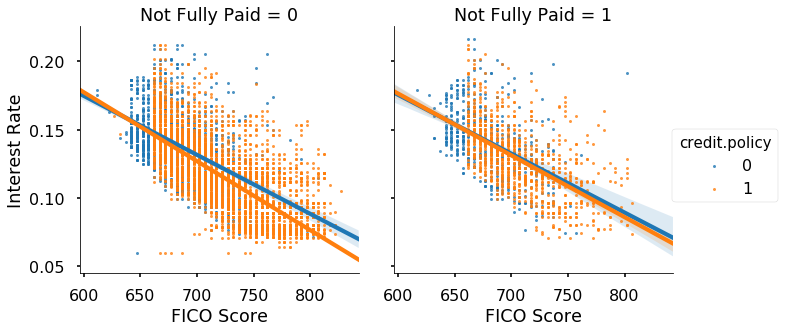

In [68]:
sns.set_context('poster')

ax = sns.lmplot(data=loans, x='fico', y='int.rate', hue='credit.policy', scatter_kws={'s': 9}, col='not.fully.paid')
ax.set_xlabels('FICO Score')
ax.set_ylabels('Interest Rate')
ax.set_titles('Not Fully Paid = {col_name}')

## Getting the Data Ready

In [69]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
credit.policy        9578 non-null int64
purpose              9578 non-null object
int.rate             9578 non-null float64
installment          9578 non-null float64
log.annual.inc       9578 non-null float64
dti                  9578 non-null float64
fico                 9578 non-null int64
days.with.cr.line    9578 non-null float64
revol.bal            9578 non-null int64
revol.util           9578 non-null float64
inq.last.6mths       9578 non-null int64
delinq.2yrs          9578 non-null int64
pub.rec              9578 non-null int64
not.fully.paid       9578 non-null int64
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


`pd.get_dummies` is a clever little tool that automatically detects categorical data (basically anything that has an object dtype) and converts it into dummy variables. In this case though, well specify which column we are interested. The new dummy columns will have the orignal column name prepended to them. Cool

In [70]:
final_data = pd.get_dummies(loans, columns=['purpose'], drop_first=True)

## Train Test Split

In [71]:
X = final_data.drop('not.fully.paid', axis=1)
y = final_data['not.fully.paid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Using Decision Tree Model

Let's begin with a basic sort of decision tree.

In [72]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [73]:
dtc_predictions = dtc.predict(X_test)
dtc_confusion_matrix = confusion_matrix(y_test, dtc_predictions)
dtc_classification_report = classification_report(y_test, dtc_predictions)

print(dtc_confusion_matrix)
print(dtc_classification_report)

[[2009  387]
 [ 385   93]]
             precision    recall  f1-score   support

          0       0.84      0.84      0.84      2396
          1       0.19      0.19      0.19       478

avg / total       0.73      0.73      0.73      2874



This is a rather disappointing result.

## Using a Random Forest Model

In [74]:
rfc = RandomForestClassifier(n_estimators=200, n_jobs=-1, verbose=1)
rfc.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [75]:
rfc_predictions = rfc.predict(X_test)
print(confusion_matrix(y_test, rfc_predictions))
print(classification_report(y_test, rfc_predictions))

[[2384   12]
 [ 468   10]]
             precision    recall  f1-score   support

          0       0.84      0.99      0.91      2396
          1       0.45      0.02      0.04       478

avg / total       0.77      0.83      0.76      2874



[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished


So the random forest performed better in this case, but it's nothing to write home about. I need to get better at reading confusion matrices and classification reports.